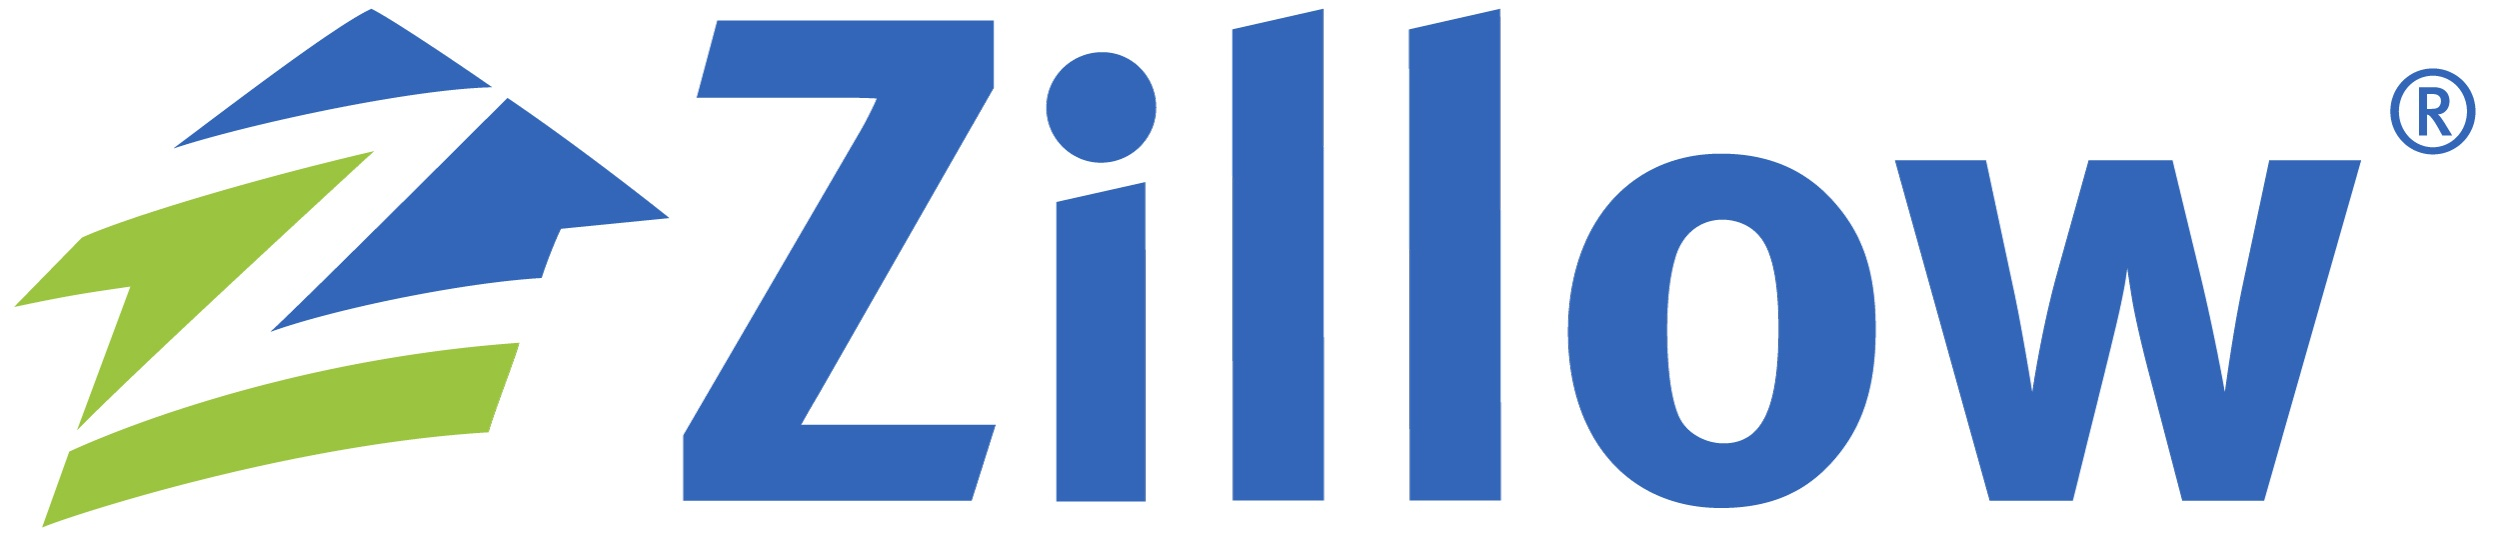

#### Imports

In [1]:
import wrangle
import explore
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:20,.2f}'.format

from math import sqrt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

#### Import LA Dataframe For Explore

In [2]:
df = wrangle.get_zillow_data(cached=True)
df_clean,df_la, df_v, df_o = wrangle.clean_zillow_data(df)
X_train, X_validate, X_test, X_train_explore, X_train_explore_scaled, y_train, y_validate, y_test, X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.split_scale(df_la)

In [3]:
df_la.shape, df_clean.shape

((4357, 14), (33494, 14))

In [4]:
X_train.shape, X_validate.shape, X_test.shape, y_train.shape

((2439, 13), (1046, 13), (872, 13), (2439, 1))

# Exploration:

**Target = Logerror** 


-A number that represents a ratio that is derived from two prior distributions - the real price distribution of homes and then Zillow's existing model of that distribution

In [5]:
X_train_explore.head()

,logerror,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
14693,-0.01,3.00,"2,198.00",34.30,-118.72,0,0,1,52.00,0.01,0.21,80.22,10.54,1.33
44513,0.15,2.00,"1,252.00",34.16,-119.18,0,0,1,58.00,0.01,0.14,104.13,40.39,1.50
47755,-0.02,2.50,"1,631.00",34.27,-119.22,0,0,1,16.00,0.01,0.09,113.84,47.52,1.20
44230,0.04,2.00,"1,320.00",34.18,-118.87,0,0,1,52.00,0.01,0.10,83.33,82.87,1.50
1402,-0.00,2.50,"1,371.00",34.26,-118.74,0,0,1,5.00,0.01,0.10,147.54,46.81,1.20


#### Inital Thoughts:

- From my inital investigation on regression project I know that room count has a large affect on taxrate and housing price.  I was unable to create a derived feature last go round so I want to test the affect of this feature now.     

- I want to examine how usefull our created feature of bedbathratio is in predicting logerror in LA County.  I chose LA County because it has the largest number of datapoints.  I want to cluster on bedbathratio, bathroomcnt, and caluculaedfinishedsquarefeet.   

<div class="alert alert-block alert-info"><b></b></div>

## Cluster One: Room Clusters

- bedbathratio   
- bathroomcnt   
- caluculaedfinishedsquarefeet   

In [6]:
X_train_scaled.describe()

,bathroomcnt,calculatedfinishedsquarefeet,latitude,longitude,LA,Orange,Ventura,age,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,bed_bath_ratio
count,"2,439.00","2,439.00","2,439.00","2,439.00","2,439.00","2,439.00","2,439.00","2,439.00","2,439.00","2,439.00","2,439.00","2,439.00","2,439.00"
mean,0.31,0.16,0.48,0.59,0.00,0.00,0.00,0.31,0.04,0.01,0.27,0.05,0.31
std,0.11,0.10,0.17,0.23,0.00,0.00,0.00,0.15,0.02,0.03,0.11,0.06,0.10
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.25,0.10,0.35,0.35,0.00,0.00,0.00,0.20,0.03,0.01,0.20,0.02,0.24
50%,0.25,0.14,0.46,0.63,0.00,0.00,0.00,0.31,0.04,0.01,0.26,0.04,0.30
75%,0.38,0.21,0.55,0.76,0.00,0.00,0.00,0.41,0.04,0.01,0.33,0.06,0.40
max,1.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00


### Step 1. Elbow Plot

   k                  sse
0  1                79.58
1  2                44.03
2  3                30.34
3  4                22.85
4  5                18.25
5  6                14.60
6  7                12.93
7  8                11.53
8  9                10.27


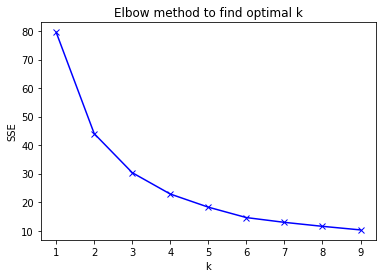

In [7]:
cluster_vars = ['bathroomcnt', 'bed_bath_ratio', 'calculatedfinishedsquarefeet']
explore.elbow_plot(X_train_scaled, cluster_vars)

#### Takeaway:

- Lets try 4 
***

### Step 2. Create Clusters

#### 2a. Train Cluster

In [8]:
train_clusters, kmeans = explore.run_kmeans(X_train, X_train_scaled, k=4, cluster_vars=cluster_vars, cluster_col_name = 'room_cluster')
train_clusters

,room_cluster
14693,3
44513,2
47755,2
44230,2
1402,2
...,...
40911,2
46958,2
45778,3
20920,2


In [9]:
# Create Clusters for Validate and Test
validate_clusters = explore.kmeans_transform(X_validate_scaled, kmeans, cluster_vars, cluster_col_name = 'room_cluster')
test_clusters = explore.kmeans_transform(X_test_scaled, kmeans, cluster_vars, cluster_col_name = 'room_cluster')

In [10]:
train_clusters.shape, validate_clusters.shape, test_clusters.shape

((2439, 1), (1046, 1), (872, 1))

In [11]:
#Visualize distribution of clusters, they do not look even
train_clusters.room_cluster.value_counts()

2    983
3    679
0    615
1    162
Name: room_cluster, dtype: int64

#### 2b. Get Centroids

In [12]:
# Function that extracts centroids from k-means
centroids = explore.get_centroids(cluster_vars, cluster_col_name='room_cluster', kmeans= kmeans)
centroids

,room_cluster,centroid_bathroomcnt,centroid_bed_bath_ratio,centroid_calculatedfinishedsquarefeet
0,0,0.21,0.44,0.11
1,1,0.60,0.20,0.42
2,2,0.27,0.28,0.11
3,3,0.39,0.26,0.23


#### 2c. Append cluster id onto X_train & X_train_scaled, then join with the centroids dataframe.


In [13]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((2439, 13), (1046, 13), (872, 13))

In [14]:
# Function that appends Clusters and Centroids to train and validate df

X_train, X_train_scaled = explore.add_to_train(train_clusters, centroids, X_train, X_train_scaled, cluster_col_name = 'room_cluster')
X_train_explore, X_train_explore_scaled = explore.add_to_train(train_clusters, centroids, X_train_explore, X_train_explore_scaled, cluster_col_name = 'room_cluster')
X_validate, X_validate_scaled = explore.add_to_train(validate_clusters, centroids, X_validate, X_validate_scaled, cluster_col_name = 'room_cluster')
X_test, X_test_scaled = explore.add_to_train(test_clusters, centroids, X_test, X_test_scaled, cluster_col_name = 'room_cluster')

In [15]:
X_train_explore_scaled.shape, X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((2439, 18), (2439, 17), (1046, 17), (872, 17))

#### 2d. Visualize room_clusters and centroids 

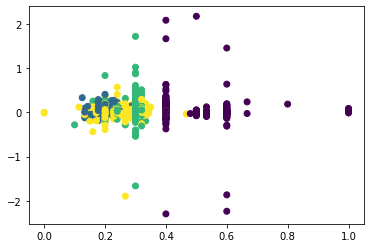

In [16]:
# Visualize 
plt.scatter(X_train_scaled.bed_bath_ratio, y_train.logerror, c=X_train_scaled.room_cluster)
plt.show()

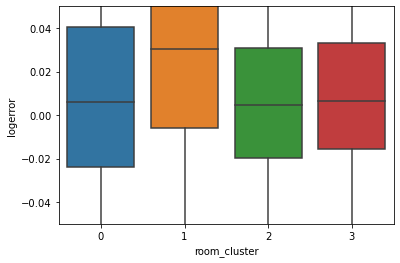

In [17]:
sns.boxplot(X_train_scaled.room_cluster, y_train.logerror)
plt.ylim(-.05,.05)
plt.show()

***

### Hypothesis Testing: (ANOVA)

Is there a staistically signfinicant difference between room_clusters and logerror?

***Null Hypothesis:*** Mean logerror is the same across all clusters

***Alternative Hypothesis:*** Mean logerror is different across clusters

**alpha=0.01**

In [18]:
#### ANOVA

cluster_0 = X_train_explore_scaled[X_train_explore_scaled.room_cluster == 0].logerror
cluster_1 = X_train_explore_scaled[X_train_explore_scaled.room_cluster == 1].logerror
cluster_2 = X_train_explore_scaled[X_train_explore_scaled.room_cluster == 2].logerror
cluster_3 = X_train_explore_scaled[X_train_explore_scaled.room_cluster == 3].logerror

from scipy.stats import f_oneway
f, p = f_oneway(cluster_0, cluster_1, cluster_2, cluster_3)
p

0.03348780211650005

***P less than 0.01 : Reject the null, indicating 99% Certainty of SIGNIFICANT DIFFERENCE in logerror between clusters***

***

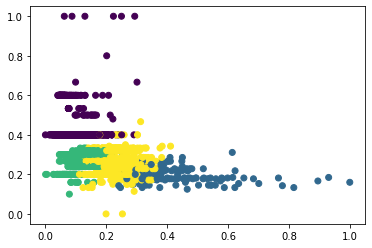

In [19]:
plt.scatter(X_train_scaled.calculatedfinishedsquarefeet, X_train_scaled.bed_bath_ratio, c=X_train_scaled.room_cluster)
plt.show()

<div class="alert alert-block alert-info"><b></b></div>

## Cluster Two: Size Clusters

- calculatedfinishedsquarefeet
- acres
- structure_dollar_per_sqft
- land_dollar_per_sqft

### Step 1. Elbow Plot

   k                  sse
0  1                68.31
1  2                49.10
2  3                36.15
3  4                30.04
4  5                25.98
5  6                22.06
6  7                19.69
7  8                17.79
8  9                16.32


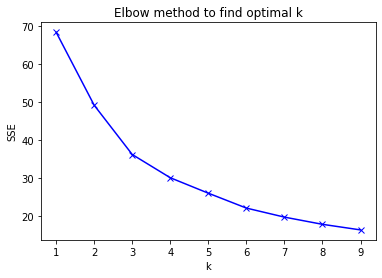

In [20]:
cluster_vars = ['calculatedfinishedsquarefeet', 'acres', 'structure_dollar_per_sqft', 'land_dollar_per_sqft']
explore.elbow_plot(X_train_scaled, cluster_vars)

**Takeaway:**

**K of 3 looks good here**

***

### Step 2. Create Clusters

#### 2a. Train Cluster

In [21]:
train_clusters, kmeans = explore.run_kmeans(X_train, X_train_scaled, k=3, cluster_vars=cluster_vars, cluster_col_name = 'size_cluster')

In [22]:
train_clusters

,size_cluster
14693,0
44513,0
47755,1
44230,0
1402,1
...,...
40911,0
46958,1
45778,0
20920,1


In [23]:
# Create Clusters for Validate and Test
validate_clusters = explore.kmeans_transform(X_validate_scaled, kmeans, cluster_vars, cluster_col_name = 'size_cluster')
test_clusters = explore.kmeans_transform(X_test_scaled, kmeans, cluster_vars, cluster_col_name = 'size_cluster')

In [24]:
#Visualize distribution of clusters, they do not look even
train_clusters.size_cluster.value_counts()

0    1041
1     936
2     462
Name: size_cluster, dtype: int64

#### 2b. Get Centroids

In [25]:
# Function that extracts centroids from k-means
centroids = explore.get_centroids(cluster_vars, cluster_col_name='size_cluster', kmeans= kmeans)
centroids

,size_cluster,centroid_calculatedfinishedsquarefeet,centroid_acres,centroid_structure_dollar_per_sqft,centroid_land_dollar_per_sqft
0,0,0.13,0.01,0.17,0.04
1,1,0.12,0.01,0.35,0.06
2,2,0.32,0.03,0.30,0.06


#### 2c. Append cluster id onto X_train & X_train_scaled, then join with the centroids dataframe.

In [26]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((2439, 17), (1046, 17), (872, 17))

In [27]:
# Function that appends Clusters and Centroids to train and validate df
X_train, X_train_scaled = explore.add_to_train(train_clusters, centroids, X_train, X_train_scaled, cluster_col_name = 'size_cluster')
X_train_explore, X_train_explore_scaled = explore.add_to_train(train_clusters, centroids, X_train_explore, X_train_explore_scaled, cluster_col_name = 'size_cluster')
X_validate, X_validate_scaled = explore.add_to_train(validate_clusters, centroids, X_validate, X_validate_scaled, cluster_col_name = 'size_cluster')
X_test, X_test_scaled = explore.add_to_train(test_clusters, centroids, X_test, X_test_scaled, cluster_col_name = 'size_cluster')

In [28]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((2439, 22), (1046, 22), (872, 22))

### Step 3: Visualize room_clusters and centroids 

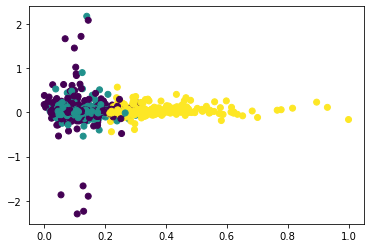

In [29]:
plt.scatter(X_train_scaled.calculatedfinishedsquarefeet, y_train.logerror, c=X_train_scaled.size_cluster)
plt.show()

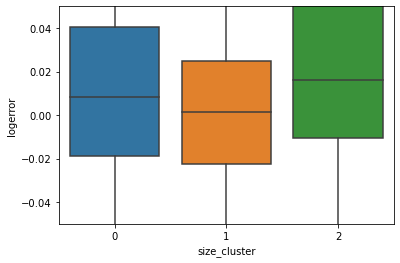

In [30]:
sns.boxplot(X_train_scaled.size_cluster, y_train.logerror)
plt.ylim(-.05,.05)
plt.show()

***

### Hypothesis Testing: (ANOVA)

Is there a staistically signfinicant difference between size_clusters and logerror?

***Null Hypothesis:*** Mean logerror is the same across all clusters

***Alternative Hypothesis:*** Mean logerror is different across clusters

**alpha=0.01**

In [31]:
#### ANOVA

cluster_0 = X_train_explore_scaled[X_train_explore_scaled.size_cluster == 0].logerror
cluster_1 = X_train_explore_scaled[X_train_explore_scaled.size_cluster == 1].logerror
cluster_2 = X_train_explore_scaled[X_train_explore_scaled.size_cluster == 2].logerror


from scipy.stats import f_oneway
f, p = f_oneway(cluster_0, cluster_1, cluster_2)
p

0.060576323634700745

***P less than 0.01 : Reject the null, indicating 99% Certainty of SIGNIFICANT DIFFERENCE in logerror between clusters***

***

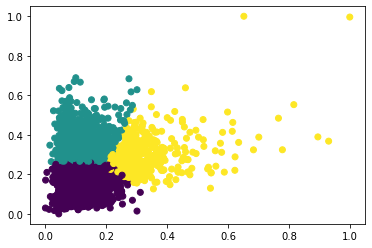

In [32]:
plt.scatter(X_train_scaled.calculatedfinishedsquarefeet, X_train_scaled.structure_dollar_per_sqft, c=X_train_scaled.size_cluster)
plt.show()

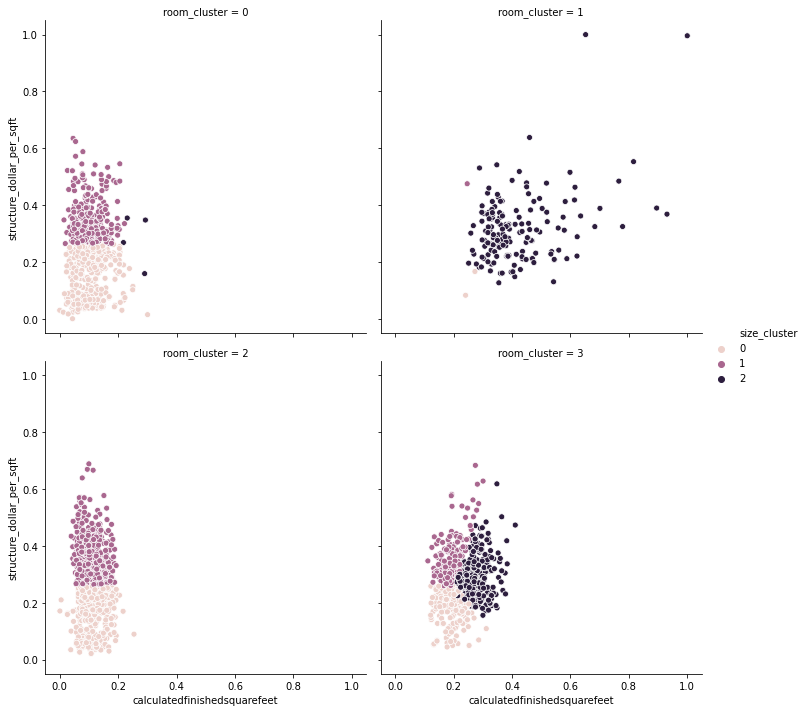

In [33]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="calculatedfinishedsquarefeet", y="structure_dollar_per_sqft", hue="size_cluster", col="room_cluster", col_wrap=2, data=X_train_scaled)
plt.show()

<div class="alert alert-block alert-info"><b></b></div>

## Cluster Three: Location Clusters (Location plus 2 created features)

- latitude
- longitude
- room_cluster
- size_cluster

### Step 1. Elbow Plot

   k                  sse
0  1             4,652.26
1  2             2,089.15
2  3             1,314.14
3  4               847.90
4  5               597.25
5  6               436.67
6  7               287.21
7  8               193.68
8  9               172.20


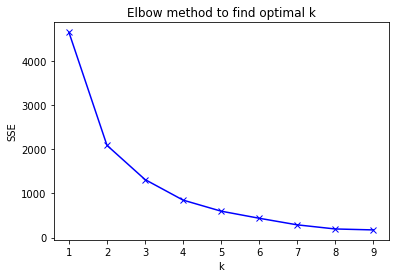

In [34]:
cluster_vars = ['latitude', 'longitude', 'room_cluster', 'size_cluster']
explore.elbow_plot(X_train_scaled, cluster_vars)

**Takeaway**

K = 3

### Step 2. Create Clusters

#### 2a. Train Cluster

In [35]:
train_clusters, kmeans = explore.run_kmeans(X_train, X_train_scaled, k=3, cluster_vars=cluster_vars, cluster_col_name = 'location_cluster')

In [36]:
# Create Clusters for Validate and Test
validate_clusters = explore.kmeans_transform(X_validate_scaled, kmeans, cluster_vars, cluster_col_name = 'location_cluster')
test_clusters = explore.kmeans_transform(X_test_scaled, kmeans, cluster_vars, cluster_col_name = 'location_cluster')

In [37]:
#Visualize distribution of clusters, they do not look even
train_clusters.location_cluster.value_counts()

2    1139
0     682
1     618
Name: location_cluster, dtype: int64

#### 2b. Get Centroids

In [38]:
# Function that extracts centroids from k-means
centroids = explore.get_centroids(cluster_vars, cluster_col_name='location_cluster', kmeans= kmeans)
centroids

,location_cluster,centroid_latitude,centroid_longitude,centroid_room_cluster,centroid_size_cluster
0,0,0.50,0.55,2.32,0.00
1,1,0.50,0.55,0.00,0.43
2,2,0.46,0.62,2.26,1.40


#### 2c. Append cluster id onto X_train & X_train_scaled, then join with the centroids dataframe.

In [39]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((2439, 22), (1046, 22), (872, 22))

In [40]:
X_train, X_train_scaled = explore.add_to_train(train_clusters, centroids, X_train, X_train_scaled, cluster_col_name = 'location_cluster')
X_train_explore, X_train_explore_scaled = explore.add_to_train(train_clusters, centroids, X_train_explore, X_train_explore_scaled, cluster_col_name = 'location_cluster')
X_validate, X_validate_scaled = explore.add_to_train(validate_clusters, centroids, X_validate, X_validate_scaled, cluster_col_name = 'location_cluster')
X_test, X_test_scaled = explore.add_to_train(test_clusters, centroids, X_test, X_test_scaled, cluster_col_name = 'location_cluster')

In [41]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((2439, 27), (1046, 27), (872, 27))

### Step 3: Visualize room_clusters and centroids 

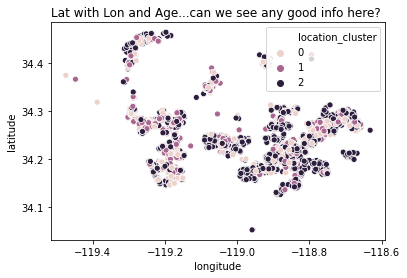

In [42]:
sns.scatterplot(x='longitude', y='latitude', hue='location_cluster', data=X_train)
plt.title("Lat with Lon and Age...can we see any good info here? ")
plt.show()

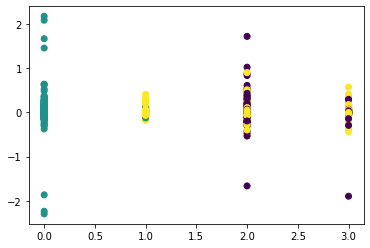

In [43]:
plt.scatter(X_train_scaled.room_cluster, y_train.logerror, c=X_train_scaled.location_cluster)
plt.show()

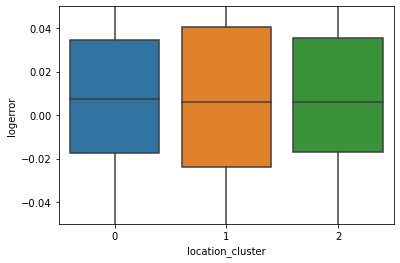

In [44]:
sns.boxplot(X_train_scaled.location_cluster, y_train.logerror)
plt.ylim(-.05,.05)
plt.show()

***

### Hypothesis Testing: (ANOVA)

Is there a staistically signfinicant difference between location_clusters and logerror?

***Null Hypothesis:*** Mean logerror is the same across all clusters

***Alternative Hypothesis:*** Mean logerror is different across clusters

**alpha=0.01**

In [45]:
#### ANOVA

cluster_0 = X_train_explore_scaled[X_train_explore_scaled.location_cluster == 0].logerror
cluster_1 = X_train_explore_scaled[X_train_explore_scaled.location_cluster == 1].logerror
cluster_2 = X_train_explore_scaled[X_train_explore_scaled.location_cluster == 2].logerror


from scipy.stats import f_oneway
f, p = f_oneway(cluster_0, cluster_1, cluster_2)
p

0.8419440773100021

***P less than 0.01 : Reject the null, indicating 99% Certainty of SIGNIFICANT DIFFERENCE in logerror between clusters***

***

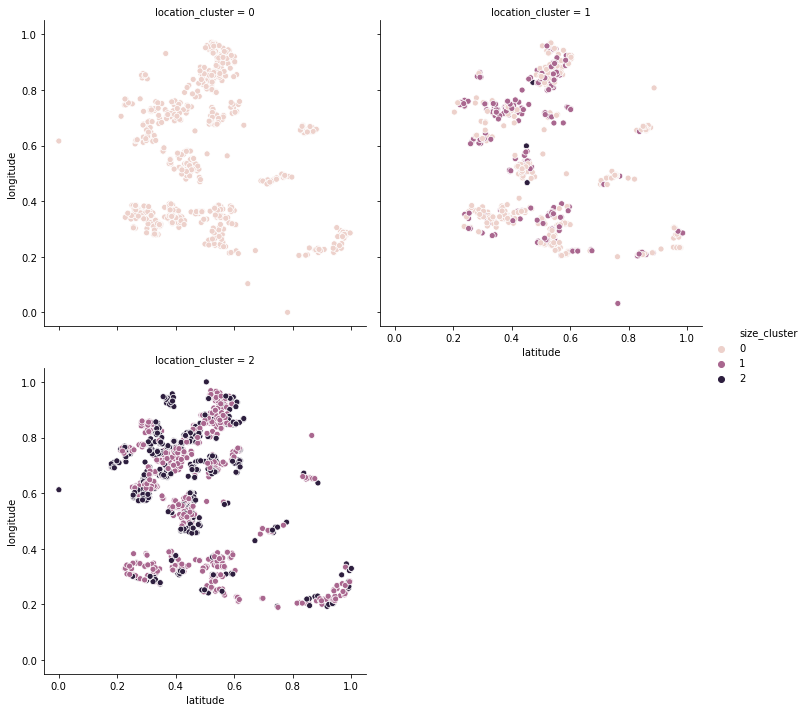

In [46]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="latitude", y="longitude", hue="size_cluster", col="location_cluster", col_wrap=2, data=X_train_scaled)
plt.show()

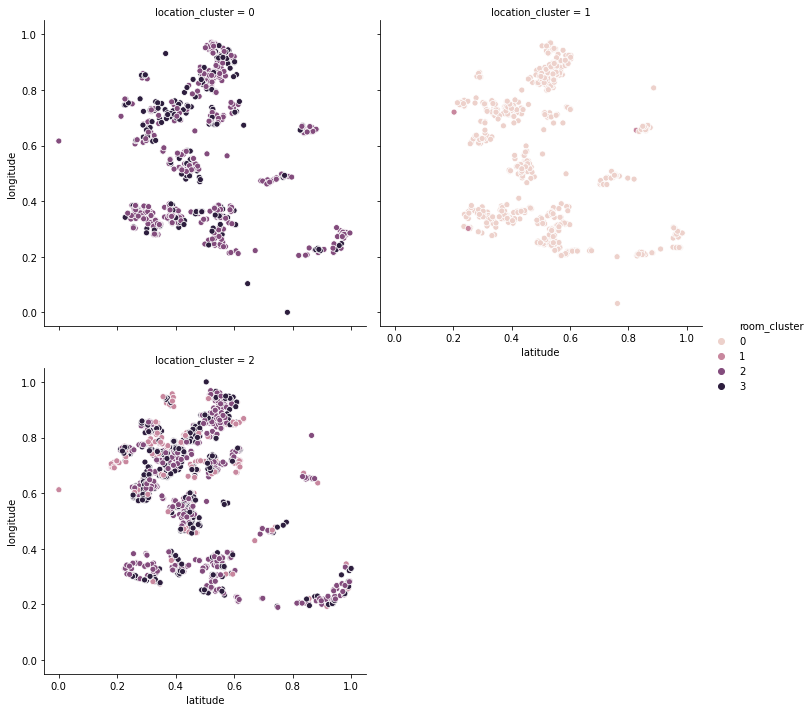

In [47]:
# visualize w/ hue="species" style="cluster"
sns.relplot(x="latitude", y="longitude", hue="room_cluster", col="location_cluster", col_wrap=2, data=X_train_scaled)
plt.show()

<div class="alert alert-block alert-info"><b></b></div>

# Characterizing Clusters 

### room_cluster

In [48]:
# Examining First Grouping (Room Cluster) Characteristics
X_train_scaled.groupby(['room_cluster'])['calculatedfinishedsquarefeet', 
                                 'bathroomcnt', 
                                  'bed_bath_ratio'].agg(['mean', 'median', 
                                               'std', 'min', 'max'])

calculatedfinishedsquarefeet                       \
                                     mean               median   
room_cluster                                                     
0                                    0.11                 0.11   
1                                    0.42                 0.38   
2                                    0.11                 0.11   
3                                    0.23                 0.23   

                                                                             \
                              std                  min                  max   
room_cluster                                                                  
0                            0.05                 0.00                 0.30   
1                            0.13                 0.24                 1.00   
2                            0.04                 0.00                 0.25   
3                            0.05                 0.11                 0.41   

                      bathroomcnt                                            \
                             mean               median                  std   
room_cluster                                                                  
0                            0.21                 0.25                 0.06   
1                            0.60                 0.56                 0.11   
2                            0.27                 0.25                 0.03   
3                            0.39                 0.38                 0.05   

                                                             bed_bath_ratio  \
                              min                  max                 mean   
room_cluster                                                                  
0                            0.00                 0.31                 0.44   
1                            0.44                 1.00                 0.20   
2                            0.12                 0.38                 0.28   
3                            0.25                 0.50                 0.26   

                                                                             \
                           median                  std                  min   
room_cluster                                                                  
0                            0.40                 0.09                 0.40   
1                            0.20                 0.04                 0.12   
2                            0.30                 0.04                 0.10   
3                            0.27                 0.05                 0.00   

                                   
                              max  
room_cluster                       
0                            1.00  
1                            0.31  
2                            0.33  
3                            0.47

**Takeaway:**   
Cluster 0 - low bed_bath_ratio (lots of bedrooms and lots of bathrooms)    
**1:1**   
Cluster 1 - large bed_bath_ratio (Many bedrooms, few to one bathroom)        
**3:1**   
Cluster 2 - med bed_bath_ratio (Many bedrooms, more than one bath)           
**2:1**   
Cluster 3 - low bed_bath_ratio (Many bedrooms, lots of bathrooms)            
**1.5:1**   

### size_cluster

In [49]:
# Examining Second Grouping (Room Cluster) Characteristics
X_train_scaled.groupby(['size_cluster'])['calculatedfinishedsquarefeet', 
                                 'acres','land_dollar_per_sqft', 
                                  'structure_dollar_per_sqft'].agg(['mean', 'median', 
                                               'std', 'min', 'max'])

calculatedfinishedsquarefeet                       \
                                     mean               median   
size_cluster                                                     
0                                    0.13                 0.13   
1                                    0.12                 0.12   
2                                    0.32                 0.29   

                                                                             \
                              std                  min                  max   
size_cluster                                                                  
0                            0.05                 0.00                 0.31   
1                            0.05                 0.01                 0.30   
2                            0.11                 0.21                 1.00   

                            acres                                            \
                             mean               median                  std   
size_cluster                                                                  
0                            0.01                 0.01                 0.02   
1                            0.01                 0.01                 0.01   
2                            0.03                 0.01                 0.06   

                                                       land_dollar_per_sqft  \
                              min                  max                 mean   
size_cluster                                                                  
0                            0.00                 0.54                 0.04   
1                            0.00                 0.25                 0.06   
2                            0.00                 1.00                 0.06   

                                                                             \
                           median                  std                  min   
size_cluster                                                                  
0                            0.02                 0.04                 0.00   
1                            0.04                 0.07                 0.00   
2                            0.05                 0.08                 0.00   

                                  structure_dollar_per_sqft  \
                              max                      mean   
size_cluster                                                  
0                            0.39                      0.17   
1                            0.99                      0.35   
2                            1.00                      0.30   

                                                                             \
                           median                  std                  min   
size_cluster                                                                  
0                            0.20                 0.07                 0.00   
1                            0.34                 0.08                 0.22   
2                            0.28                 0.09                 0.13   

                                   
                              max  
size_cluster                       
0                            0.26  
1                            0.69  
2                            1.00

**Takeaway**

Cluster 0 - Low Cost Per square foot   
**low_cost**   
Cluster 1 - Medium Cost Per Squre Foot   
**medium_cost**   
Cluster 2 - High Cost per squre foot   
**high_cost**   

### location_cluster

In [50]:
# Examining Third Grouping (loation Cluster) Characteristics
X_train_scaled.groupby(['location_cluster'])['latitude', 
                                 'longitude','room_cluster', 
                                  'size_cluster'].agg(['mean', 'median', 
                                               'std', 'min', 'max'])

latitude                       \
                                 mean               median   
location_cluster                                             
0                                0.50                 0.49   
1                                0.50                 0.51   
2                                0.46                 0.44   

                                                            \
                                  std                  min   
location_cluster                                             
0                                0.18                 0.00   
1                                0.17                 0.20   
2                                0.16                 0.00   

                                                 longitude  \
                                  max                 mean   
location_cluster                                             
0                                1.00                 0.55   
1                                0.98                 0.55   
2                                1.00                 0.62   

                                                            \
                               median                  std   
location_cluster                                             
0                                0.53                 0.23   
1                                0.52                 0.24   
2                                0.68                 0.21   

                                                            \
                                  min                  max   
location_cluster                                             
0                                0.00                 0.97   
1                                0.03                 0.97   
2                                0.19                 1.00   

                         room_cluster                                      \
                                 mean median                  std min max   
location_cluster                                                            
0                                2.32      2                 0.47   2   3   
1                                0.00      0                 0.07   0   1   
2                                2.26      2                 0.69   1   3   

                         size_cluster                                      
                                 mean median                  std min max  
location_cluster                                                           
0                                0.00      0                 0.00   0   0  
1                                0.43      0                 0.51   0   2  
2                                1.40      1                 0.49   1   2

**Takeaway:**

Cluster 0 - Large # of Rooms, Medium
Cluster 1 - Medium # of Rooms, Small
Cluster 2 - Small # of Rooms, High


<div class="alert alert-block alert-info"><b></b></div>

# Modeling

### Feature Selection:

In [51]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((2439, 27), (1046, 27), (872, 27))

In [52]:
# Split clusters in to dummy varaibles for modeling

X_train_scaled = pd.get_dummies(X_train_scaled,
                           columns=['room_cluster','size_cluster','location_cluster'])
X_validate_scaled = pd.get_dummies(X_validate_scaled,
                           columns=['room_cluster','size_cluster','location_cluster'])
X_test_scaled = pd.get_dummies(X_test_scaled,
                           columns=['room_cluster','size_cluster','location_cluster'])


X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((2439, 34), (1046, 34), (872, 34))

In [53]:
# Which Features KBest?

top_3 = SelectKBest(f_regression, k=3).fit(X_train_scaled, y_train)
top_3_support = top_3.get_support()
X_train_scaled.loc[:,top_3_support].columns.tolist()

['centroid_calculatedfinishedsquarefeet_y', 'centroid_acres', 'room_cluster_1']

In [54]:
# Which Features RFE?

lm = LinearRegression()
rfe = RFE(lm, n_features_to_select = 5)
rfe.fit(X_train_scaled, y_train)
ranks = rfe.ranking_
names = X_train_scaled.columns.tolist()
pd.DataFrame({'features': names, 'rank': ranks}).set_index('rank')

,features
rank,
24,bathroomcnt
27,calculatedfinishedsquarefeet
26,latitude
28,longitude
23,LA
22,Orange
21,Ventura
30,age
1,taxrate


**Takeaway**

***Going to model on top features (Ranked #1) Five Total***
1. size_cluster_0
2. size_cluster_1
3. size_cluster_2
4. centroid_structure_dollar_per_sqft
5. centroid_bathroomcnt

***

### Building the Model 

MVP - 3 Features

1. size_cluster_0
2. size_cluster_1
3. size_cluster_2
4. centroid_structure_dollar_per_sqft
5. centroid_bathroomcnt

***Target = logerror***

*Use all four common regression model types: Linear Regression, LassoLars, Polynomial Features, TweedieRegressor*

Establish Baseline based on target mean, if model Root Mean Squared Error (RMSE) is lower than the baseline the model performs better


#### Create a Baseline:

In [55]:
#Visualize Target
mean = np.mean(y_train)
median = np.median(y_train)

In [56]:
print("The mean value of y_train is")
mean

The mean value of y_train is


logerror                   0.02
dtype: float64

In [57]:
print("The median value of y_train is")
median

The median value of y_train is


0.00633097268129

In [58]:
y_train.describe()

,logerror
count,"2,439.00"
mean,0.02
std,0.15
min,-2.30
25%,-0.02
50%,0.01
75%,0.04
max,2.18


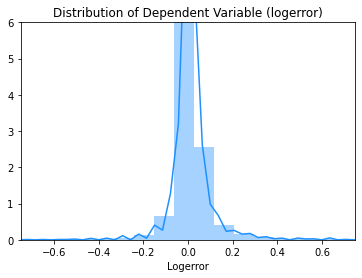

In [59]:
sns.distplot(y_train, color="dodgerblue", label="Compact", rug = False, axlabel = 'Logerror')
plt.xlim(-.75,.75)
plt.ylim(0, 6)
plt.title("Distribution of Dependent Variable (logerror)")
plt.show()

**Takeaway**

***Normal Distribution, will use Mean Value for Baseline***

#### Calcuate Baseline RMSE

In [60]:
# Mean Value
y_train.shape

(2439, 1)

In [61]:
# encode as variable
# np.full modiefies shape turns value in to a full series object
baseline_rmse = mean_squared_error(y_train, np.full(2439, np.mean(y_train)))**(1/2)
print (f'The baseline_rmse is {baseline_rmse}')  # Model Error To Beat 0.16287423418470207

The baseline_rmse is 0.15444613142452873


#### Specifiy Variables for Modeling

In [62]:
# Only Use centroid_calculatedfinishedsquarefeet_x, structure_dollar_per_sqft, centroid_land_dollar_per_sqft

X_train_scaled = X_train_scaled[['size_cluster_0', 'size_cluster_1', 'size_cluster_2', 'centroid_structure_dollar_per_sqft', 'centroid_bathroomcnt']]
X_validate_scaled = X_validate_scaled[['size_cluster_0', 'size_cluster_1', 'size_cluster_2', 'centroid_structure_dollar_per_sqft', 'centroid_bathroomcnt']]
X_test_scaled = X_test_scaled[['size_cluster_0', 'size_cluster_1', 'size_cluster_2', 'centroid_structure_dollar_per_sqft', 'centroid_bathroomcnt']]

In [63]:
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((2439, 5), (1046, 5), (872, 5))

### Train

#### Linear Regression

In [64]:
# Make Model
lm = LinearRegression(normalize=True)
# Fit Model
lm.fit(X_train_scaled, y_train)
# Make Predictions
lm_pred = lm.predict(X_train_scaled)
# Compute root mean squared error
lm_rmse = mean_squared_error(y_train, lm_pred)**(1/2)
lm_rmse

0.154272082737467

#### Lassolars

In [65]:
# Make a model
lars = LassoLars(alpha=1)
# Fit a model
lars.fit(X_train_scaled, y_train)
# Make Predictions
lars_pred = lars.predict(X_train_scaled)
# Computer root mean squared error
lars_rmse = mean_squared_error(y_train, lars_pred)**(1/2)
lars_rmse

0.15444613142452873

#### Polynomial Featues

In [66]:
# Make a model
pf = PolynomialFeatures(degree=2)

# Fit and Transform model
# to get a new set of features..which are the original features sqauared
X_train_squared = pf.fit_transform(X_train_scaled)
X_validate_squared = pf.transform(X_validate_scaled)  
X_test_squared = pf.transform(X_test_scaled)          

# Feed new features in to linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_train_squared, y_train)
# Make predictions
lm_squared_pred = lm_squared.predict(X_train_squared)
# Compute root mean squared error
lm_squared_rmse = mean_squared_error(y_train, lm_squared_pred)**(1/2)
lm_squared_rmse

0.15412153760084238

#### Tweedie Regressor

In [67]:
# Make Model
tw = TweedieRegressor(power=0, alpha=0.1) # 0 = normal distribution
# Fit Model
tw.fit(X_train_scaled, y_train)
# Make Predictions
tw_pred = tw.predict(X_train_scaled)
# Compute root mean squared error
tw_rmse = mean_squared_error(y_train, tw_pred)**(1/2)
tw_rmse

0.15428225423383896

**Takeaway:**

- Top 3 preforming models are Linear, Polynomial, Tweedie
- These models will move on to Validate

### Validate:

#### Linear Regression

In [68]:
# Make Predictions
lm_pred_v = lm.predict(X_validate_scaled)
# Compute root mean squared error
lm_rmse_v = mean_squared_error(y_validate, lm_pred_v)**(1/2)
lm_rmse_v

0.15159479710572063

#### Ploynomial Features

In [69]:
# Feed new features in to linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_train_squared, y_train)
# Make predictions
lm_squared_pred_v = lm_squared.predict(X_validate_squared)
# Compute root mean squared error
lm_squared_rmse_v = mean_squared_error(y_validate, lm_squared_pred_v)**(1/2)
lm_squared_rmse_v

0.15181247675748796

#### Tweedie Regressor

In [70]:
# Make predictions
tw_pred_v = tw.predict(X_validate_scaled)
# Compute root mean squared error
tw_rmse_v = mean_squared_error(y_validate, tw_pred_v)**(1/2)
tw_rmse_v

0.15155117587804168

***

**Takeaway:**

On unseen data the Polynomial Model performs the best and will move on to the test data



***

### Test:

#### Linear Regression

In [71]:
# Make predictions
lm_pred_t1 = lm.predict(X_test_scaled)
# Compute root mean squared error
lm_rmse_t1 = round(mean_squared_error(y_test, lm_pred_t1)**(1/2),5)
lm_rmse_t1

0.16158

#### Average Model Error (Validate + Test) / 2

In [72]:
# Avg. Error = (Validate Error + Test Error) /2 - Average preformance of model works on unseen data
model_error = round((lm_rmse_v + lm_rmse_t1) / 2 , 5)
print(f'The average error for our model is {model_error}%')

The average error for our model is 0.15659%


#### Percentage Improvement over Baseline

In [73]:
# Calcuating % improvement
# First: work out the difference (increase) between the two numbers you are comparing
difference = (baseline_rmse - lm_rmse_t1)
# Then: divide the increase by the original number and multiply the answer by 100
percent_improve = round((difference / baseline_rmse) * 100, 2)
print(f'The % improvement for our model is {percent_improve}%')

The % improvement for our model is -4.62%


**Takeaway:**

- Linear Regression is the model that best predicts logerror
- This model produces an average error of 0.17%
- This represents a **-6.87%** improvement over baseline


<div class="alert alert-block alert-info"><b></b></div>

# Summary


Exploration:

    Filtered data down to 13 variables:

    - wrangle module

    Developed Clusters:

    A. room_cluster (information that reflects the number and size of rooms per unit)
    B. size_cluster (information that reflects the size of the home and property in squarefeet)
    C. location_clusters (informaiton that reflects the location of proerties along with previous clusters)

    Hypothesis Testing: (Clusters vs logerror)

    - All Clusters (room_cluster, size_cluster, location_cluster) sujbected to ANOVA
    - All Tests returned p-values < 0.01, 99% Certainty of SIGNIFICANT DIFFERENCE in logerror between clusters
    - Suggests clusters are good features for predicting logerror

Clusters should yeild results that allow our model to beat baseline

***

Target Selection:

    Target = logerror

    Feature Selection:
        KBest: Top 3
            structure_dollar_per_sqft
            land_dollar_per_sqft
            location_cluster_2

- RFE: Top 5
    - size_cluster_0
    - size_cluster_1
    - size_cluster_2
    - centroid_structure_dollar_per_sqft
    - centroid_bathroomcnt


Top Five Features for RFE were selected for model use, based on algorithim selection criteria

***

Modeling:

4 models: Linear Regression, LassoLars, Polynomial Features, TweedieRegressor

    First Iteration: (5 Features)
    Features = size_cluster_0, size_cluster_1, size_cluster_2, centroid_structure_dollar_per_sqft, centroid_bathroomcnt Best Model = Linear Regression Model Avg. RMSE of 0.17 % -6.87% Improvement over baseline

Linear models might not be best approach to predicting logerror with this dataset


<div class="alert alert-block alert-info"><b></b></div>

# Next Steps

***

**Too Much Data?:**    
Investigate impact of further reducing outliers with regards to logerror. When clusters were visualized outliers were clearly producing a negative impact. Currently the dataset is relying on arbitrary cut offs to lmiit outliers, however utilizing industy standards such as IQR might yeild better results.
 
 

**Best Features?:**
Current model is bulit on suggestions from RFE, all of which include features created by clustering.  However further examination of feature data may reveal new clusters that are better able to predict logerror.  



**New Models?:**
Using features from RFE failed to produce a model that was able to beat baseline.  There exists a chance that linear models might not the best approch to predict logerror. 



**Other Counties?:**
This model is deployed on only the largest and most complicated dataset.  Further investation in to other counties may result in a better fitting model that produces a lower aggrigated RMSE. 


***